In [1]:
import pyam

import numpy as np
import xarray as xr

from aneris.grid import grid
from pathlib import Path

<IPython.core.display.Javascript object>

# Data Set Up

In [2]:
base_path = Path(
    "C:/Users/gidden/IIASA/RESCUE - Documents/WP 1/data/gridding_process_files"
)

In [3]:
idxr = xr.open_dataarray(base_path / "iso_mask.nc", chunks={"iso": 10})
proxy = xr.open_dataarray(
    base_path / "proxy_rasters/anthro_CO2.nc", chunks={"year": 1, "sector": 1}
)
df = pyam.IamDataFrame(
    base_path
    / "../iam_files/cmip6/REMIND-MAGPIE_SSP5-34-OS/B.REMIND-MAGPIE_Harmonized-DB_emissions_downscaled.csv",
    region="iso",
).data

C:\Users\gidden\Miniconda3\envs\aneris\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file C:\Users\gidden\IIASA\RESCUE - Documents\WP 1\data\gridding_process_files\..\iam_files\cmip6\REMIND-MAGPIE_SSP5-34-OS\B.REMIND-MAGPIE_Harmonized-DB_emissions_downscaled.csv


In [4]:
sector_mapping = {
    "Aircraft": "AIR",
    "International Shipping": "SHP",
    "Agricultural Waste Burning": "AWB",
    "Agriculture": "AGR",
    "Energy Sector": "ENE",
    "Forest Burning": "FRTB",
    "Grassland Burning": "GRSB",
    "Industrial Sector": "IND",
    "Peat Burning": "PEAT",
    "Residential Commercial Other": "RCO",
    "Solvents Production and Application": "SLV",
    "Transportation Sector": "TRA",
    "Waste": "WST",
}

In [5]:
df["gas"] = df.variable.apply(lambda x: x.split("|")[3])
df["sector"] = df.variable.apply(lambda x: x.split("|")[4]).replace(sector_mapping)
data = df[
    (df.sector.isin(np.unique(proxy.sector))) & (df.gas.isin(np.unique(proxy.gas)))
]
data = data.rename(columns={"region": "iso"})
data.head()

,model,scenario,iso,variable,unit,year,value,gas,sector
410,REMIND-MAGPIE,SSP5-34-OS-V25,abw,CEDS+|9+ Sectors|Emissions|CO2|Agriculture|Har...,Mt CO2/yr,2015,0.0,CO2,AGR
411,REMIND-MAGPIE,SSP5-34-OS-V25,abw,CEDS+|9+ Sectors|Emissions|CO2|Agriculture|Har...,Mt CO2/yr,2020,0.0,CO2,AGR
412,REMIND-MAGPIE,SSP5-34-OS-V25,abw,CEDS+|9+ Sectors|Emissions|CO2|Agriculture|Har...,Mt CO2/yr,2030,0.0,CO2,AGR
413,REMIND-MAGPIE,SSP5-34-OS-V25,abw,CEDS+|9+ Sectors|Emissions|CO2|Agriculture|Har...,Mt CO2/yr,2040,0.0,CO2,AGR
414,REMIND-MAGPIE,SSP5-34-OS-V25,abw,CEDS+|9+ Sectors|Emissions|CO2|Agriculture|Har...,Mt CO2/yr,2050,0.0,CO2,AGR


# Perform Calculation

In [7]:
kg_per_mt = 1e9
s_per_yr = 365 * 24 * 60 * 60

ds = grid(data, proxy, idxr, as_flux=True) * kg_per_mt / s_per_yr
ds

C:\Users\gidden\Miniconda3\envs\aneris\lib\site-packages\dask\array\core.py:4830: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
root - WARNING: Missing from x iso: ['Pitcairn', 'Northern Mariana Islands', 'Tuvalu', 'Mayotte', 'Jersey', 'Guernsey', 'Bonaire, Sint Eustatius and Saba', 'San Marino', 'Monaco', 'Norfolk Island', 'Saint Helena, Ascension and Tristan da Cunha', 'Svalbard and Jan Mayen', 'Andorra', 'Anguilla', 'Isle of Man', 'Nauru']



<xarray.DataArray (year: 10, gas: 1, sector: 7, lat: 280, lon: 720, month: 12)>
dask.array<truediv, shape=(10, 1, 7, 280, 720, 12), dtype=float64, chunksize=(1, 1, 1, 280, 720, 12), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2015 2020 2030 2040 2050 2060 2070 2080 2090 2100
  * gas      (gas) object 'CO2'
  * sector   (sector) object 'AGR' 'ENE' 'IND' 'RCO' 'SLV' 'TRA' 'WST'
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
da = ds.sel(year=2015, sector="ENE").mean(dim="month").compute()

C:\Users\gidden\Miniconda3\envs\aneris\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


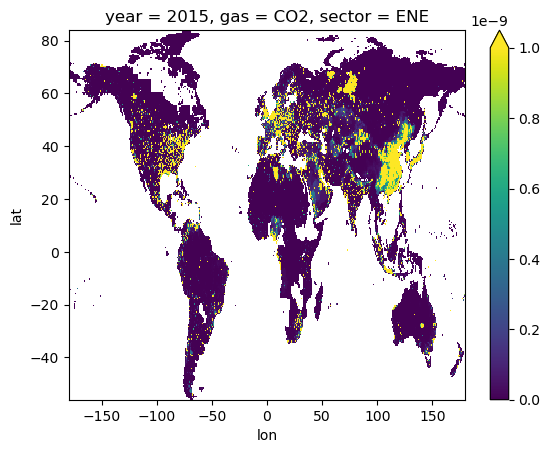

In [35]:
xr.where(da > 0, da, np.nan).plot(vmax=1e-9)

# Check against previous data

In [12]:
exp_raster = xr.open_dataset(
    base_path
    / "../iam_files/cmip6/REMIND-MAGPIE_SSP5-34-OS/CO2-em-anthro_input4MIPs_emissions_CMIP_REMIND-MAGPIE-SSP5-34-OS-V1_gn_201501-210012.nc",
    chunks={"time": 12, "sector": 1},
)["CO2-em-anthro"]
exp_raster = exp_raster.sel(sector=[0, 1, 2, 3, 5, 6, 7])
exp_raster["sector"] = ["AGR", "ENE", "IND", "RCO", "SLV", "TRA", "WST"]
exp_raster

<xarray.DataArray 'CO2-em-anthro' (time: 120, sector: 7, lat: 360, lon: 720)>
dask.array<getitem, shape=(120, 7, 360, 720), dtype=float32, chunksize=(12, 1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * sector   (sector) <U3 'AGR' 'ENE' 'IND' 'RCO' 'SLV' 'TRA' 'WST'
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
Attributes:
    units:         kg m-2 s-1
    cell_methods:  time: mean
    long_name:     CO2-em-anthro

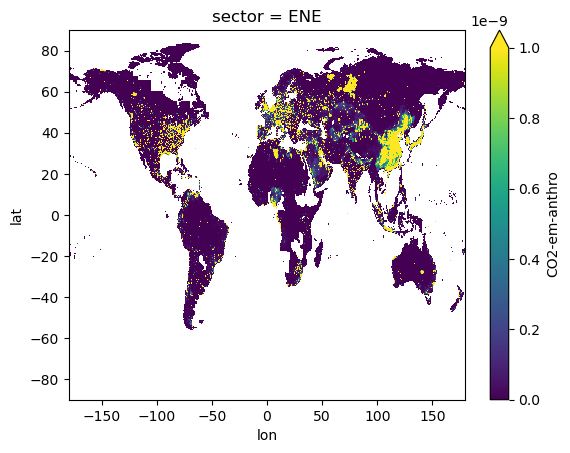

In [34]:
da_exp = exp_raster.isel(time=slice(0, 12)).sel(sector="ENE").mean(dim="time").compute()
xr.where(da_exp > 0, da_exp, np.nan).plot(vmax=1e-9)

In [13]:
def grid_diff(exp_raster, obs_raster, sector, relative=False):
    exp = exp_raster.isel(time=slice(0, 12)).sel(sector=sector).mean(dim="time")
    obs = obs_raster.sel(year=2015, gas="CO2", sector=sector).mean(dim="month")
    if relative:
        return ((exp - obs) / exp).compute()
    else:
        return (exp - obs).compute()

In [15]:
gdiff = grid_diff(exp_raster, ds, sector="TRA", relative=False)

C:\Users\gidden\Miniconda3\envs\aneris\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


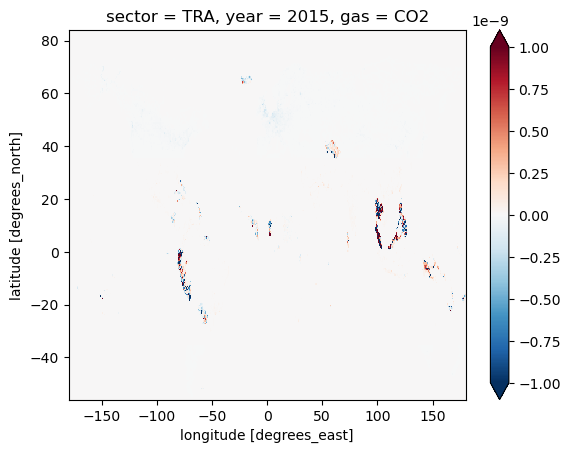

In [16]:
gdiff.plot(vmin=-1e-9, vmax=1e-9, cmap="RdBu_r")

In [17]:
# checks first year values across all sectors
def check_values(exp_raster, obs_raster, sum_dim=None):
    exp = (
        (exp_raster.isel(time=slice(0, 12)).mean(dim="time")).sum(dim=sum_dim).compute()
    )
    obs = (
        (obs_raster.sel(year=2015, gas="CO2").mean(dim="month")).sum(sum_dim).compute()
    )
    return exp, obs

In [18]:
s_exp, s_obs_us = check_values(exp_raster, ds, sum_dim=["lat", "lon"])

C:\Users\gidden\Miniconda3\envs\aneris\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [20]:
(100 * (s_exp - s_obs_us) / s_exp).to_dataframe(name="rel_diff")  # units: %

,year,gas,rel_diff
sector,,,
AGR,2015,CO2,NaN
ENE,2015,CO2,-0.047221
IND,2015,CO2,0.068426
RCO,2015,CO2,0.047668
SLV,2015,CO2,-0.023627
TRA,2015,CO2,-0.060756
WST,2015,CO2,0.109542
